In [54]:
import torch
import numpy as np
from time import time
import math
from scipy.signal.windows import hann
import matplotlib.pyplot as plt

In [16]:
time_list = []

for i in range(10):
    start = time()
    A = np.ones((2500,2500))
    B = np.ones((2500,2500)) *0.1

    for i in range(100):
        A = A*B
    
    end = time()-start
    time_list.append(end)
    
print("Average time used = {0:1.2f}+-{1:1.2f}".format(np.average(time_list), np.std(time_list)))

Average time used = 2.81+-0.03


In [17]:
start = time()
A = torch.ones((2500,2500))
B = torch.ones((2500,2500))

for i in range(100):
    A = A*B
    
print("Time used = {}".format(time()-start))

Time used = 0.2999405860900879


# Tensor Creation

In [10]:
start = time()
A = torch.zeros((10000,10000))
A = A.cuda()
end = time()-start
print(end)

0.11591649055480957


In [11]:
A

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [19]:
start = time()
A = torch.zeros((10000,10000), device='cuda:0')
end = time()-start
print(end)

0.0005278587341308594


In [13]:
A

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

# FFT

In [20]:
def create_filtersv2(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*torch.sin(2*math.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*torch.cos(2*math.pi*k*s/n_fft)
    
    return wsin,wcos


In [40]:
def create_filtersv3(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = hann(n_fft, sym=False) # same as 0.5-0.5*torch.cos(2*math.pi*s/(n_fft))
        window_mask = torch.tensor(window_mask).float()
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*torch.sin(2*math.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*torch.cos(2*math.pi*k*s/n_fft)
    
    return wsin,wcos

In [42]:
def create_filters(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = np.arange(0, n_fft, 1)
    wsin = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    wcos = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = hann(n_fft, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*np.sin(2*np.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*np.cos(2*np.pi*k*s/n_fft)
    
    return wsin,wcos


In [30]:
from time import time

time_list = []
for i in range(50):
    start = time()
    wsin, wcos = create_filtersv2(4000,500, mode="stft")
    with torch.cuda.device(0):
        wsin = torch.Tensor(wsin).cuda()
        wcos = torch.Tensor(wcos).cuda()
    end = time()-start
    time_list.append(end)
print("Average time used = {0:1.4f}+-{1:1.4f}".format(np.average(time_list), np.std(time_list)))

Average time used = 0.0795+-0.0038


In [41]:
from time import time

time_list = []
for i in range(50):
    start = time()
    wsin, wcos = create_filtersv3(4000,500, mode="stft")
    with torch.cuda.device(0):
        wsin = torch.Tensor(wsin).cuda()
        wcos = torch.Tensor(wcos).cuda()
    end = time()-start
    time_list.append(end)
print("Average time used = {0:1.4f}+-{1:1.4f}".format(np.average(time_list), np.std(time_list)))

Average time used = 0.0809+-0.0072


In [43]:
from time import time

time_list = []
for i in range(50):
    start = time()
    wsin, wcos = create_filters(4000,500, mode="stft")
    with torch.cuda.device(0):
        wsin = torch.Tensor(wsin).cuda()
        wcos = torch.Tensor(wcos).cuda()
    end = time()-start
    time_list.append(end)
print("Average time used = {0:1.4f}+-{1:1.4f}".format(np.average(time_list), np.std(time_list)))

Average time used = 0.3732+-0.1284


In [55]:
s = torch.arange(0, 4000, 1.)
manual_hann = 0.5-0.5*torch.cos(2*math.pi*s/(4000))

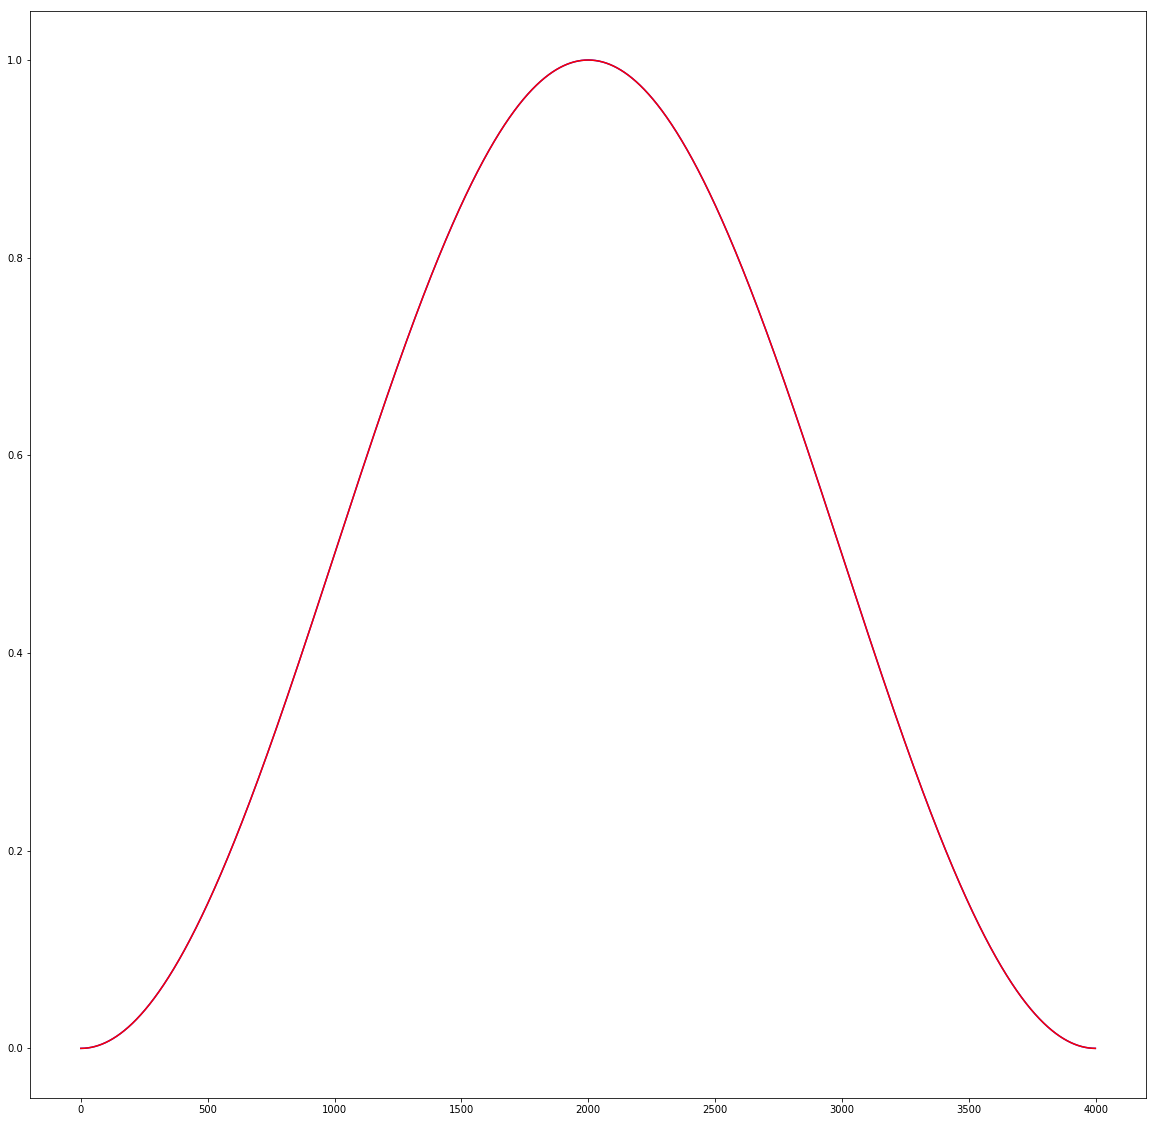

In [70]:
plt.figure(figsize=(20,20))
plt.plot(hann(4000, sym=False),'b')
plt.plot(manual_hann.numpy(),'r')